In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import matplotlib as mpl
from matplotlib.pyplot import cm

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [5]:
import statsmodels.stats.multitest as multi

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

## Compile RNA data

In [9]:
def combine_rna(lst_rna,genes):
    compiled=pd.DataFrame()
    for x in lst_rna:
        df=pd.read_csv(x,delimiter="\t")
        del df["IID"]
        df=df.set_index("FID")
        df=df.T
        compiled=compiled.append(df)
    #subset for genes
    compiled=compiled[compiled.index.isin(genes)]
    #replace missing values with nan
    compiled=compiled.replace(-9,np.nan)
    #get median
    compiled=compiled.groupby(compiled.index).median()
    #remove patients with more than 10% of phenotypes as missing
    df_counts=compiled.isnull().sum().reset_index()
    remove=df_counts[df_counts[0]>0.1*741]["index"].tolist()
    
    compiled=compiled.T
    compiled=compiled[~compiled.index.isin(remove)]
    return(compiled)
    

In [10]:
lst=["/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/tpm/tumor/pheno_all_zcancer","/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/tumor/pheno_all_zcancer","/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/pancanatlas/tumor/pheno_all_zcancer"]

In [11]:
#get only genes found in at least 2 rna sources
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/heritability/data/immune.genes.2.rna.txt")["genes"].tolist()

In [12]:
df=combine_rna(lst,genes)

In [13]:
df.to_csv("../data/rna.3source.median.tsv",sep="\t")

## Run PCA

In [14]:
for_pca=df.fillna(df.mean())

In [15]:
#scale data
scaler=StandardScaler()
scaler.fit(for_pca)
X_scaled=scaler.transform(for_pca)

In [16]:
pca = PCA(n_components=30)

In [17]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### plot variance explained

In [18]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

Text(0, 0.5, 'variance explained')

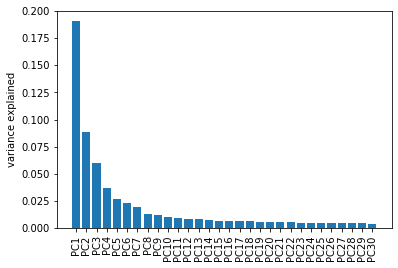

In [20]:
plt.bar(["PC"+str(i) for i in range(1,31)],pca.explained_variance_ratio_.tolist())
plt.xticks(rotation=90)
plt.ylabel("variance explained")

### Get loadings

In [22]:
df_comp=pd.DataFrame(pca.components_)
df_comp.columns=for_pca.columns
df_comp=df_comp.reset_index()
df_comp["index"]=df_comp["index"]+1
df_comp["index"]="PC"+df_comp["index"].astype(str)
df_comp=df_comp.set_index("index")

In [23]:
df_comp=df_comp.T

### Get PCA dataframe

In [24]:
X_pca=pca.transform(X_scaled)

In [25]:
df_pca=pd.DataFrame(X_pca)
df_pca.index=for_pca.index
df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]

In [26]:
df_pca=df_pca.reset_index()

In [27]:
df_pca=df_pca.rename(columns={"index":"FID"})

In [28]:
df_pca.head()

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,TCGA-02-0047,1.784878,-13.136039,4.176151,2.460379,0.400791,-0.148301,2.791125,-0.105427,0.010000,...,-2.464629,3.669819,-1.757806,0.806212,-1.200512,-0.039146,-2.078590,-2.634051,-1.570734,0.223195
1,TCGA-02-0055,16.918275,4.185216,-1.992375,10.003828,8.132131,1.488629,-2.358534,-1.154207,-6.485802,...,0.364337,-2.695741,-0.792019,2.634374,-1.454988,-0.775779,-0.707870,2.015481,-2.467236,0.846121
2,TCGA-02-2486,19.289779,4.730709,2.554748,-5.560061,11.298650,-4.962418,-3.220631,3.133177,1.483733,...,3.497146,1.412505,0.819513,-1.449864,3.329233,0.289595,-0.034710,0.410468,-0.360635,-1.092754
3,TCGA-06-0129,9.078634,-6.140409,-11.869147,-8.358886,-9.092636,-3.038194,2.242685,7.884882,4.774648,...,-4.282662,0.825599,0.022448,2.210730,-2.568260,-1.734072,2.830679,-1.922433,-1.587254,3.049808
4,TCGA-06-0130,32.573026,1.812918,-5.821779,4.159500,0.385653,0.254406,-2.122521,1.247581,-6.140820,...,1.708832,-3.085545,5.226017,1.450088,-0.281352,-1.383502,1.266337,1.608212,-2.558684,-0.133564


### Run regression with principal components

In [29]:
df=df.reset_index().rename(columns={"index":"FID"})

In [30]:
all_pheno=pd.merge(df_pca,df,on=["FID"],how="left")

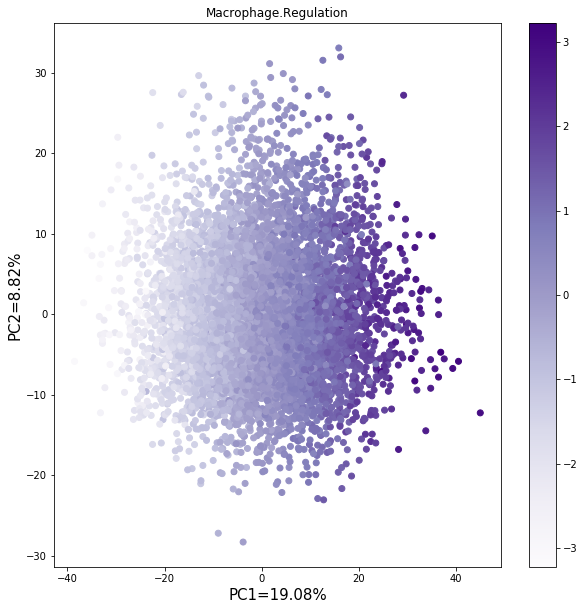

In [31]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"
gene="Macrophage.Regulation"

plt.scatter(all_pheno[x], all_pheno[y], c=all_pheno[gene],cmap="Purples")
plt.colorbar()

plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
plt.title(gene)
plt.savefig("../plots/"+x+"."+gene+".pdf")

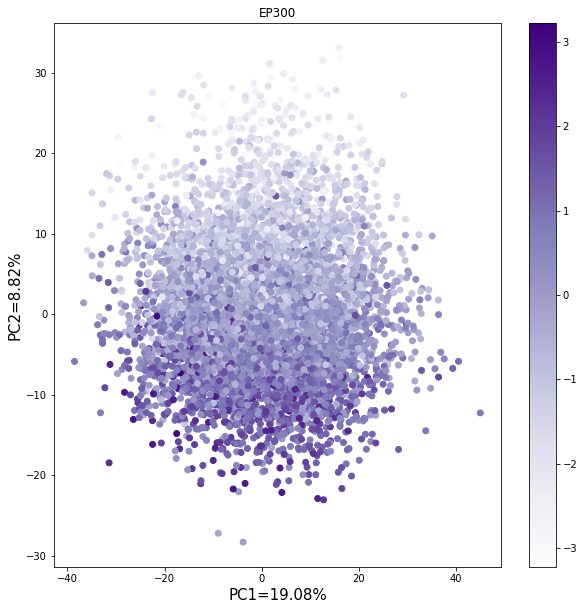

In [33]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"
gene="EP300"

plt.scatter(all_pheno[x], all_pheno[y], c=all_pheno[gene],cmap="Purples")
plt.colorbar()

plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
plt.title(gene)
plt.savefig("../plots/"+x+"."+gene+".pdf")

## Run OLS with cancer type

In [37]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
df_pca["cancer"]=df_pca["FID"].map(mp)

In [38]:
df_pca_cancer=df_pca.join(pd.get_dummies(df_pca["cancer"]))

In [39]:
pcs=df_pca_cancer.columns[1:11]
cancers=df_pca_cancer.columns[32:]

In [40]:
cancer=[]
pc=[]
pval=[]

for x in pcs:
    for c in cancers:
        ols = linear_model.LinearRegression()
        X=df_pca_cancer[c].values.reshape(-1, 1)
        y=df_pca_cancer[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        cancer.append(c)
        pc.append(x)
        pval.append(results.pvalues[1])


In [41]:
cancer_ols=pd.DataFrame({"cancer":cancer,"pc":pc,"pvalue":pval})

In [42]:
cancer_ols.to_csv("../data/pcs.cancer.type.ols.csv",index=None,sep="\t")

## Run association with Age/Sex

In [43]:
cov=pd.read_csv("/cellar/users/mpagadal/Data/plink-associations/covs/cov-immune-filt.txt",delimiter="\t")
mp_age=dict(zip(cov["FID"],cov["age"]))

In [44]:
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
mp_sex=dict(zip(fam[0],fam[4]))

In [45]:
df_pca["age"]=df_pca["FID"].map(mp_age)
df_pca["sex"]=df_pca["FID"].map(mp_sex)

In [46]:
pcs=df_pca.columns[1:11]

In [47]:
var=[]
pc=[]
pval=[]

for x in pcs:
    for c in ["age","sex"]:
        ols = linear_model.LinearRegression()
        X=df_pca[c].values.reshape(-1, 1)
        y=df_pca[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        var.append(c)
        pc.append(x)
        pval.append(results.pvalues[1])

In [48]:
age_sex_ols=pd.DataFrame({"variable":var,"pc":pc,"pvalue":pval})

In [49]:
age_sex_ols=age_sex_ols.pivot(index="pc",columns="variable",values="pvalue")

In [50]:
age_sex_ols.to_csv("../data/pcs.age.sex.ols.csv",index=None,sep="\t")

## Run PCA for just heritable phenotypes

In [51]:
genes=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/heritability/data/gcta_significant_genes.txt",header=None)[0].tolist()

In [52]:
df=combine_rna(lst,genes)

In [53]:
df.head()

,ADCY7,ALOX5AP,AMPD3,APITD1,B2M,BSG,BTN3A2,C3AR1,CANX,CAPZA2,...,TLR2,TNFRSF1A,TNFSF13B,TRA2B,TRAF6,TREX1,UAP1,VAMP3,VSIG4,WDR54
TCGA-02-0047,1.538334,-0.041444,0.020717,-0.720732,-0.381976,-1.365388,0.124617,-0.136196,0.668002,-0.592197,...,0.359785,-0.351784,0.472789,-1.018725,-1.091620,-0.592197,-0.543513,0.720732,-0.187537,-0.918546
TCGA-02-0055,0.052245,1.605730,0.178496,0.351784,1.419554,0.856599,0.887147,1.018725,-0.465370,0.714367,...,1.686671,0.610295,0.519653,-0.642327,-0.199762,-0.031338,2.641070,1.213340,1.213340,0.560703
TCGA-02-2486,0.136196,2.241403,0.687660,1.267664,1.893185,-0.826830,1.018725,1.686671,0.136196,0.536422,...,1.267664,0.648915,1.534121,-1.135422,0.324048,0.747859,0.887147,1.900427,1.686671,0.585319
TCGA-06-0129,2.638257,-0.010273,0.351784,0.010273,0.700514,-0.175539,0.610295,1.410699,-0.585319,-0.781640,...,1.356312,-1.900427,0.700514,1.223048,1.130339,0.838697,0.199762,-0.526759,0.754049,-0.285841
TCGA-06-0130,2.241403,0.700514,1.893185,1.258162,1.896823,-0.574582,1.415149,2.036834,-0.741594,0.635657,...,2.241403,0.560703,1.896823,-0.404357,-0.898625,-0.154711,2.040281,0.781640,1.170831,-0.694126


In [54]:
for_pca=df.fillna(df.mean())

In [55]:
scaler=StandardScaler()
scaler.fit(for_pca)
X_scaled=scaler.transform(for_pca)

In [56]:
pca = PCA(n_components=30)

In [57]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [58]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

Text(0, 0.5, 'variance explained')

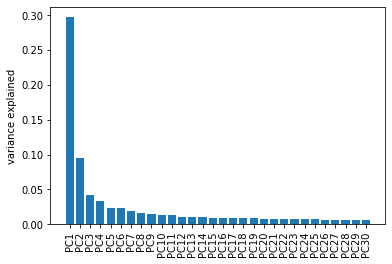

In [59]:
plt.bar(["PC"+str(i) for i in range(1,31)],pca.explained_variance_ratio_.tolist())
plt.xticks(rotation=90)
plt.ylabel("variance explained")

In [60]:
df_comp=pd.DataFrame(pca.components_)
df_comp.columns=for_pca.columns
df_comp=df_comp.reset_index()
df_comp["index"]=df_comp["index"]+1
df_comp["index"]="PC"+df_comp["index"].astype(str)
df_comp=df_comp.set_index("index")

In [61]:
df_comp=df_comp.T

In [62]:
X_pca=pca.transform(X_scaled)

In [63]:
df_pca=pd.DataFrame(X_pca)
df_pca.index=for_pca.index
df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]

## Profile the principal components

In [64]:
#get principal components
df_pca=df_pca.reset_index()
df_pca=df_pca.rename(columns={"index":"FID"})
df=df.reset_index().rename(columns={"index":"FID"})

In [65]:
#get rna
rna=pd.read_csv("../data/rna.3source.median.tsv",delimiter="\t").rename(columns={"Unnamed: 0":"FID"})
all_pheno=pd.merge(df_pca,rna,on=["FID"],how="left")

In [66]:
neoantigen=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/neoantigen/pheno_all_zcancer",delimiter="\t")
neoantigen=neoantigen.replace(-9,np.nan)

In [67]:
tmb=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/phenotypes/processed_phenos/tmb/pheno_all_zcancer",delimiter="\t")

In [68]:
all_pheno=pd.merge(all_pheno,neoantigen,on=["FID"],how="left")
all_pheno=pd.merge(all_pheno,tmb,on=["FID"],how="left")

In [70]:
neoantigen.head()

,FID,IID,I.thresh2,II.thresh20,I.thresh0.5,II.thresh10
0,TCGA-RZ-AB0B,TCGA-RZ-AB0B,0.385320,0.253347,0.419296,0.125661
1,TCGA-V3-A9ZX,TCGA-V3-A9ZX,-1.534121,-1.959964,-0.841621,-1.356312
2,TCGA-V3-A9ZY,TCGA-V3-A9ZY,0.385320,-1.959964,-0.237202,-1.356312
3,TCGA-V4-A9E5,TCGA-V4-A9E5,-0.015667,-0.078412,0.419296,-0.674490
4,TCGA-V4-A9E7,TCGA-V4-A9E7,1.150349,1.356312,0.419296,1.150349


In [71]:
pcs=all_pheno.columns[1:11]

In [72]:
all_pheno=all_pheno.fillna(0)

In [73]:
phenos1=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t").columns[2:].tolist()
phenos2=["PSMB5","PSMB6","TAP1","TAP2","ERAP1","ERAP2","CANX","B2M","HLA.A","HLA.B","HLA.C"]
phenos3=[x for x in all_pheno if "dice" in x]+[x for x in all_pheno if "LM22" in x]
phenos4=["Missense_Mutation","I.thresh2","II.thresh20","CD274","CTLA4"]

In [74]:
phenos=phenos1+phenos2+phenos3+phenos4

In [95]:
pc=[]
pheno=[]
beta=[]
pval=[]

for x in pcs:
    for p in phenos:
        ols = linear_model.LinearRegression()
        X=all_pheno[p].values.reshape(-1, 1)
        y=all_pheno[x].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        beta.append(results.params[1])
        pval.append(-np.log10(results.pvalues[1]))
        pheno.append(p)
        pc.append(x)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


In [96]:
df_ols=pd.DataFrame({"pc":pc,"pheno":pheno,"beta":beta,"pvalue":pval})

In [97]:
df_ols["pvalue"]=df_ols["pvalue"].replace(np.inf,np.nan)
df_ols["pvalue"]=df_ols["pvalue"].replace(np.nan,df_ols["pvalue"].max())

In [98]:
df_ols["beta"]=abs(df_ols["beta"])

3


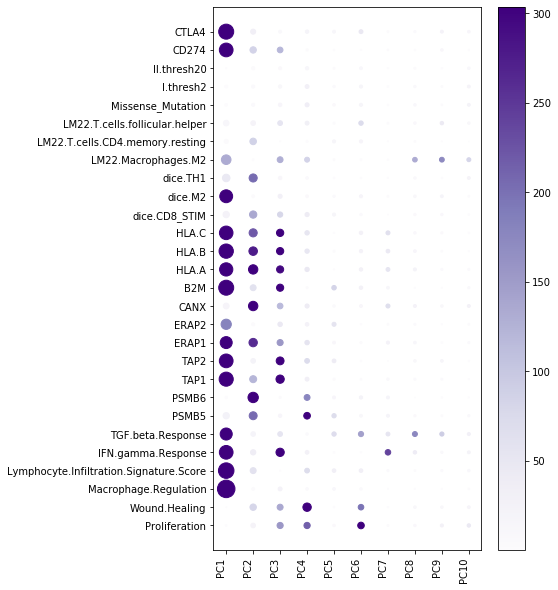

In [99]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(6, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="Purples"# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    print(len(c))
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_ols['pc'],
    y=df_ols['pheno'],
    size=df_ols['beta'],
    color=df_ols['pvalue']
)

plt.savefig("../plots/pca.infiltration.pdf")

In [100]:
df_ols[df_ols["pheno"]=="CD274"]

,pc,pheno,beta,pvalue
26,PC1,CD274,3.759759,303.556694
54,PC2,CD274,0.814804,84.724038
82,PC3,CD274,0.647357,120.375295
110,PC4,CD274,0.087478,3.370316
138,PC5,CD274,0.035995,1.076964
166,PC6,CD274,0.022967,0.571952
194,PC7,CD274,0.057648,2.715116
222,PC8,CD274,0.041473,1.751532
250,PC9,CD274,0.126690,13.890399
278,PC10,CD274,0.031317,1.294227


In [80]:
df_size=df_ols.copy()

In [81]:
df_size["beta"]=np.where(df_size["pc"]=="PC1",4,df_size["beta"])
df_size["beta"]=np.where(df_size["pc"]=="PC2",3,df_size["beta"])
df_size["beta"]=np.where(df_size["pc"]=="PC3",2,df_size["beta"])
df_size["beta"]=np.where(df_size["pc"]=="PC4",1,df_size["beta"])

3


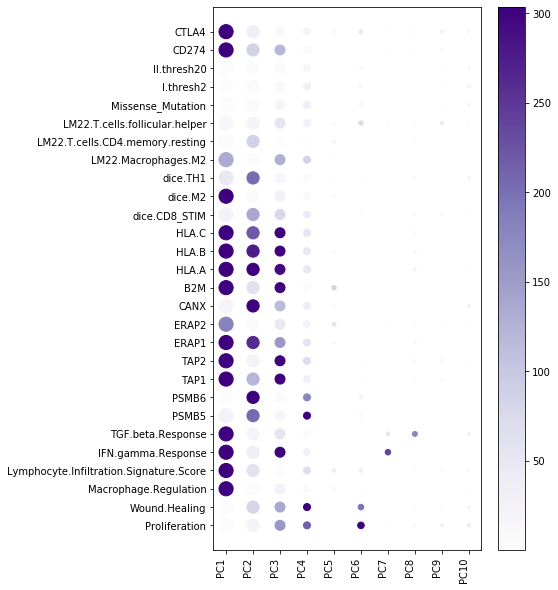

In [82]:
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(6, 10))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="Purples"# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    print(len(c))
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_size['pc'],
    y=df_size['pheno'],
    size=df_size['beta'],
    color=df_size['pvalue']
)

plt.savefig("../plots/pca.infiltration.size.pdf")

## Get PCs for both gcta and all phenos

In [83]:
gcta=pd.read_csv("../phenotypes/pca.pheno.heritable.tsv",delimiter="\t")
pheno=pd.read_csv("../phenotypes/pca.pheno.tsv",delimiter="\t")

In [84]:
all_pca=pd.merge(gcta,pheno,on=["FID","IID"],suffixes=("_all","_gcta"))

In [85]:
del all_pca["FID"]
del all_pca["IID"]

In [86]:
all_pca=abs(all_pca)

In [87]:
all_pca.head()

,PC1_all,PC2_all,PC3_all,PC4_all,PC5_all,PC6_all,PC7_all,PC8_all,PC9_all,PC10_all,PC1_gcta,PC2_gcta,PC3_gcta,PC4_gcta,PC5_gcta,PC6_gcta,PC7_gcta,PC8_gcta,PC9_gcta,PC10_gcta
0,1.313917,3.680450,2.795920,0.931772,1.040448,1.262522,0.303719,0.858296,0.403122,1.461166,1.784737,13.135899,4.176562,2.460464,0.402273,0.146864,2.791070,0.106347,0.010014,2.205814
1,10.244986,0.949089,0.799498,4.054130,0.696704,4.205255,2.016507,1.337999,0.534810,1.097614,16.918073,4.185367,1.991697,10.002315,8.131188,1.491205,2.363470,1.172913,6.483940,2.196060
2,11.269077,3.172041,2.635656,1.957362,1.474086,2.568502,2.037273,1.580704,1.359331,1.795065,19.290299,4.729950,2.553463,5.562093,11.303328,4.955355,3.219751,3.138193,1.477335,3.424130
3,7.580760,3.180431,2.907188,2.147122,1.487361,3.849738,1.881467,1.429179,1.600554,0.506509,9.078792,6.140856,11.869096,8.355814,9.092941,3.041594,2.247341,7.898231,4.755307,0.433890
4,15.852036,0.546411,0.425554,0.254357,1.312823,0.784748,0.974725,0.324995,0.463043,2.749847,32.572916,1.812889,5.821054,4.160008,0.383361,0.253562,2.124778,1.230449,6.145078,0.060518


In [88]:
all_pca_pearson=all_pca.corr(method="pearson")

In [89]:
cols=[x for x in all_pca_pearson.columns if "gcta" in x]
ind=[x for x in all_pca_pearson.columns if "all" in x]

In [90]:
all_pca_pearson_compare=all_pca_pearson.loc[ind,cols]

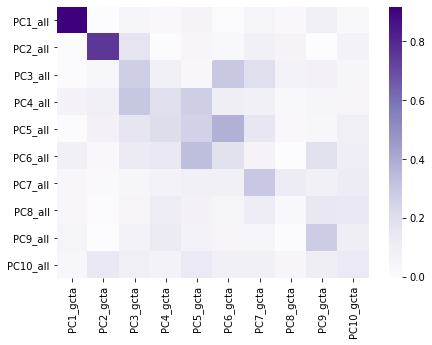

In [91]:
f=plt.figure(figsize=(7,5))
sns.heatmap(all_pca_pearson_compare,cmap="Purples")
plt.savefig("../plots/pca.heatmap.pdf")